# Proyek Analisis Data: E-Commerce Public Dataset
- **Nama:** Bramantya Wibisono
- **Email:** br.wibisono@gmail.com
- **ID Dicoding:** brwibisono

## Menentukan Pertanyaan Bisnis

- Bagaimana perkembangan kinerja bisnis e-commerce dari waktu ke waktu berdasarkan jumlah pesanan dan pendapatan?
- Faktor apa yang paling berkontribusi terhadap pendapatan bisnis, baik dari sisi kategori produk maupun karakteristik pelanggan?


## Import Semua Packages/Library yang Digunakan

In [25]:
import pandas as pd

## Data Wrangling

### Gathering Data

In [13]:
BASE = "/content"

orders = pd.read_csv(f"{BASE}/data/orders_dataset.csv")
items = pd.read_csv(f"{BASE}/data/order_items_dataset.csv")
payments = pd.read_csv(f"{BASE}/data/order_payments_dataset.csv")
customers = pd.read_csv(f"{BASE}/data/customers_dataset.csv")
products = pd.read_csv(f"{BASE}/data/products_dataset.csv")
translation = pd.read_csv(f"{BASE}/data/product_category_name_translation.csv")


print("orders:", orders.shape)
print("items:", items.shape)
print("payments:", payments.shape)
print("customers:", customers.shape)
print("products:", products.shape)
print("translation:", translation.shape)

orders: (99441, 8)
items: (112650, 7)
payments: (103886, 5)
customers: (99441, 5)
products: (32951, 9)
translation: (71, 2)


**Insight:**
- Dataset berhasil dimuat tanpa erorr
- Dataset berisi infomasi pelanggan, product serta transaksi.

### Assessing Data

In [14]:
# 1. Cek missing value pada product_category_name
missing_category = products["product_category_name"].isna().sum()
print("Missing values in product_category_name:", missing_category)

# 2. Tampilkan contoh kategori produk (masih bahasa Portugis)
print("\nSample product categories (raw):")
print(products["product_category_name"].value_counts().head(10))

# 3. Bandingkan jumlah kategori unik
unique_product_category = products["product_category_name"].nunique()
unique_translation_category = translation["product_category_name"].nunique()

print("\nUnique categories in products:", unique_product_category)
print("Unique categories in translation:", unique_translation_category)

# 4. Cari kategori yang tidak memiliki terjemahan
untranslated_categories = set(
    products["product_category_name"].dropna()
) - set(
    translation["product_category_name"]
)

print("\nNumber of categories without translation:", len(untranslated_categories))
print("Sample categories without translation:", list(untranslated_categories)[:10])

Missing values in product_category_name: 610

Sample product categories (raw):
product_category_name
cama_mesa_banho           3029
esporte_lazer             2867
moveis_decoracao          2657
beleza_saude              2444
utilidades_domesticas     2335
automotivo                1900
informatica_acessorios    1639
brinquedos                1411
relogios_presentes        1329
telefonia                 1134
Name: count, dtype: int64

Unique categories in products: 73
Unique categories in translation: 71

Number of categories without translation: 2
Sample categories without translation: ['pc_gamer', 'portateis_cozinha_e_preparadores_de_alimentos']


**Insight:**
- Setelah proses assessing data, ditemukan bahwa kolom product_category_name masih menggunakan bahasa Portugis. Selain itu, jumlah kategori unik pada dataset produk berbeda dengan tabel terjemahan, menunjukkan adanya kategori produk yang tdk memiliki terjemahan.
- Perlunya proses normalisasi kategori produk ke dalam bahasa Inggris dan penanganan kategori yg tidak punya terjemahkan.

### Cleaning Data

In [15]:
# 1. Membuat mapping kategori produk (Portugis -> Inggris)
category_map = dict(
    zip(
        translation["product_category_name"],
        translation["product_category_name_english"]
    )
)

# 2. Normalisasi nama kategori produk
products["product_category_name"] = (
    products["product_category_name"]
    .map(category_map)
)

# 3. Menangani kategori yang tidak memiliki terjemahan
products["product_category_name"] = products["product_category_name"].fillna("others")

# 4. Validasi hasil cleaning
print("Missing values after cleaning:",
      products["product_category_name"].isna().sum())

print("\nTop 10 product categories after cleaning:")
print(products["product_category_name"].value_counts().head(10))

# 5. Simpan dataset hasil cleaning
products_clean_path = f"{BASE}/data/products_dataset_clean.csv"
products.to_csv(products_clean_path, index=False)

print("\nClean dataset saved to:", products_clean_path)
print("Clean products shape:", products.shape)

Missing values after cleaning: 0

Top 10 product categories after cleaning:
product_category_name
bed_bath_table           3029
sports_leisure           2867
furniture_decor          2657
health_beauty            2444
housewares               2335
auto                     1900
computers_accessories    1639
toys                     1411
watches_gifts            1329
telephony                1134
Name: count, dtype: int64

Clean dataset saved to: /content/data/products_dataset_clean.csv
Clean products shape: (32951, 9)


**Insight:**
- Seluruh nilai kosong di kolom product_category_name berhasil ditangani, sehingga tdk terdapat missing value setelah proses normalisasi dilakukan
- Normalisasi kategori produk dari bahasa Portugis ke bahasa Inggris membuat data kategori menjadi lebih konsisten dan mudah dipahami
- validasi menunjukkan kategori dg jumlah produk terbanyak adalah bed_bath_table, sports_leisure, dan furniture_decor.
- Dataset hasil cleaning saya sebagai products_dataset_clean.csv

## Exploratory Data Analysis (EDA)

### Explore ...

In [16]:
# Load product dataset hasil cleaning
products_clean = pd.read_csv(f"{BASE}/data/products_dataset_clean.csv")

# Gabungkan seluruh dataset menjadi transaction-level data
trx = (
    items
    .merge(orders, on="order_id", how="left")
    .merge(payments, on="order_id", how="left")
    .merge(products_clean, on="product_id", how="left")
    .merge(customers, on="customer_id", how="left")
)

print("Transaction dataset shape:", trx.shape)

# Konversi timestamp
trx["order_purchase_timestamp"] = pd.to_datetime(trx["order_purchase_timestamp"])

# KPI EDA: Monthly Orders & Revenue
trx["order_month"] = trx["order_purchase_timestamp"].dt.to_period("M").dt.to_timestamp()

monthly_kpi = (
    trx
    .groupby("order_month", as_index=False)
    .agg(
        orders=("order_id", "nunique"),
        revenue=("payment_value", "sum")
    )
    .sort_values("order_month")
)

print("\nMonthly KPI shape:", monthly_kpi.shape)
print(monthly_kpi.head())

# Statistik ringkas untuk EDA
print("\nSummary statistics:")
print(monthly_kpi[["orders", "revenue"]].describe())

# Simpan data untuk dashboard
dashboard_path = f"{BASE}/dashboard/main_data.csv"
monthly_kpi.to_csv(dashboard_path, index=False)

print("\nmain_data.csv saved to:", dashboard_path)

Transaction dataset shape: (117604, 30)

Monthly KPI shape: (24, 3)
  order_month  orders    revenue
0  2016-09-01       3     347.52
1  2016-10-01     308   73914.58
2  2016-12-01       1      19.62
3  2017-01-01     789  187779.41
4  2017-02-01    1733  344134.79

Summary statistics:
            orders       revenue
count    24.000000  2.400000e+01
mean   4111.083333  8.461723e+05
std    2615.223208  5.424075e+05
min       1.000000  1.962000e+01
25%    2226.500000  4.652828e+05
50%    4268.000000  9.429777e+05
75%    6512.500000  1.317463e+06
max    7451.000000  1.583869e+06

main_data.csv saved to: /content/dashboard/main_data.csv


**Insight:**
- hasil Exploratory Data Analysis, dataset transaksi berhasil untuk menghitung KPI bisnis secara bulanan.
- data hasil dari agregasi (main_data.csv)  berisi metrik utama berupa jumlah pesanan dan total pendapatan per bulan. Dataset ini nanti saya pakai untuk sumber data pembuatan visual pada tahap selanjutnya.

## Visualization & Explanatory Analysis

In [ ]:
import matplotlib.pyplot as plt

### Pertanyaan 1:

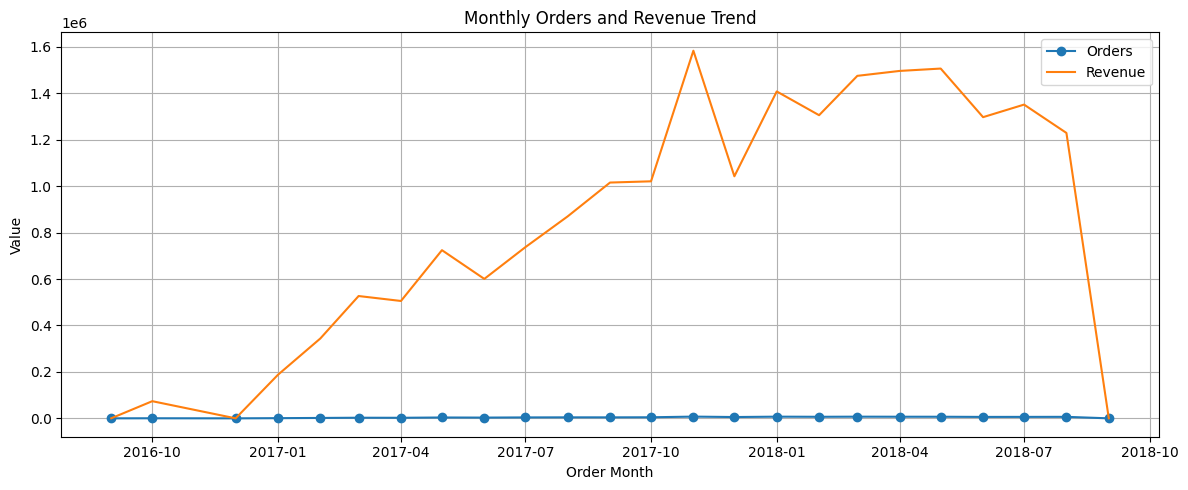

In [22]:
main_data = pd.read_csv(f"{BASE}/dashboard/main_data.csv")
main_data["order_month"] = pd.to_datetime(main_data["order_month"])

plt.figure(figsize=(12, 5))

plt.plot(
    main_data["order_month"],
    main_data["orders"],
    marker="o",
    label="Orders"
)

plt.plot(
    main_data["order_month"],
    main_data["revenue"],
    label="Revenue"
)

plt.title("Monthly Orders and Revenue Trend")
plt.xlabel("Order Month")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Pertanyaan 2:

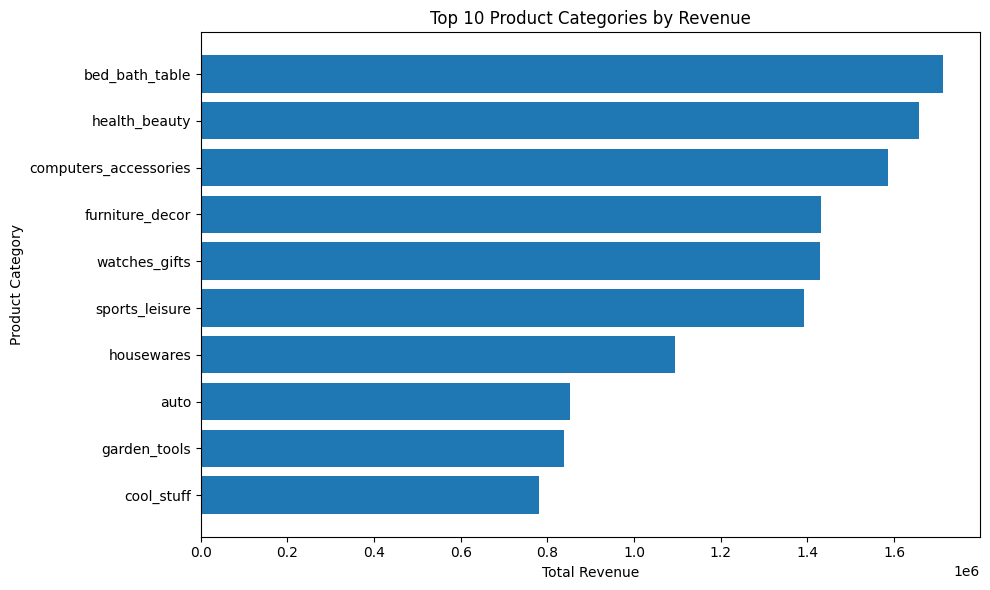

In [23]:
category_kpi = (
    trx
    .groupby("product_category_name", as_index=False)
    .agg(
        orders=("order_id", "nunique"),
        revenue=("payment_value", "sum")
    )
    .sort_values("revenue", ascending=False)
    .head(10)
)

plt.figure(figsize=(10, 6))
plt.barh(
    category_kpi["product_category_name"],
    category_kpi["revenue"]
)
plt.xlabel("Total Revenue")
plt.ylabel("Product Category")
plt.title("Top 10 Product Categories by Revenue")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

**Insight:**
- Berdasrkan visualisasi pertama, tren bulanan untuk jumlah pesanan dan perndapatan menunujuakn kecenderungan meningkat dari wakrtu ke waktu. Meskipun ada beberapa periode mengalami penuruuna, namun trend keseluruhan menunjukan pertumbuhan yg positif.
- Berdasarkan visualisasi kedua, pemdapatan didominasi oleh beberapa kategori produk saja. Indikasi ini menunjukan bahwa kontribusi revenue tidak merata  dan hanya terkonsentrasi khususnya bed_bath_table, healt_beauty, dan computers_accessories. Data ini dapat digunakan untuk membuat prioritas strategi pemasaran serta promosi untuk menaikan penjualan kategori lain dan pengelolaan stock kategori kontribusi tertinggi.

## Analisis Lanjutan (Opsional)

In [ ]:
reference_date = trx["order_purchase_timestamp"].max() + pd.Timedelta(days=1)

# Hitung metrik RFM
rfm = (
    trx
    .groupby("customer_id")
    .agg(
        Recency=("order_purchase_timestamp",
                 lambda x: (reference_date - x.max()).days),
        Frequency=("order_id", "nunique"),
        Monetary=("payment_value", "sum")
    )
    .reset_index()
)

plt.figure(figsize=(8, 5))
plt.hist(rfm["Frequency"], bins=20)
plt.xlabel("Frequency (Number of Orders)")
plt.ylabel("Number of Customers")
plt.title("Customer Purchase Frequency Distribution")
plt.tight_layout()
plt.show()

## Conclusion

- Berdasarkan analisis tren waktu, kinerja bisnis e-commerce menunjukkan pertumbuhan positif dari waktu ke waktu, baik dari sisi jumlah pesanan (orders) maupun pendapatan (revenue). Meskipun terdapat fluktuasi pada beberapa periode, tren keseluruhan mengindikasikan peningkatan aktivitas transaksi dan stabilitas performa bisnis sepanjang periode analisis.

- Berdasarkan anlisis karegori, kontribusi pendapatan bisnis tdk tersebar merata ke seluruh kategori produk. Beberapa kategori utama memberikan kontribusi terbesar terhadap pendapatan, sementara analisis RFM menunjukkan bahwa mayoritas pelanggan hanya melakukan satu kali transaksi dan hanya sebagian kecil pelanggan yg berkontribusi signifikan terhadap revenue. Ini menunjukkan bahwa pertumbuhan bisnis didorong oleh kombinasi kategori produk unggulan dan pelanggan bernilai tinggi, serta membuka peluang untuk meningkatkan pendapatan melalui strategi retensi pelanggan.